# Import Packages

In [6]:
import nidaqmx
from nidaqmx import Task
import numpy as np
from numpy import sin, cos, arctan, pi
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.animation
from matplotlib.lines import Line2D

# Define Functions

In [7]:
# set potential profile and acquire data 
def pot_step_and_measure(pot_profile, samp_num):
    
    ''' 
    This function writes a potential profile into the ao0 output of the potentiostat to set the potential 
    between the WE and RE. At the same time, potential acquisitions are being made by the channel ai0 and ai1
    inputs. ai0 measures the WE potential while ai1 measures the potential across the measurement resistor Rm
    which measures the potential between the WE and RE and ai0 at the measurement resistor
    
    The potential profile and sampling rate should be defined prior to running this function. 

    Outputs: 
        acquired_data = nested array containing potentials measured at the WE and Rm. 
    
    '''    
    
    
    '''Get device name '''
    
    # get a list of all devices connected
    all_devices = list(nidaqmx.system.System.local().devices)
    # get name of first device
    dev_name = all_devices[0].name
    #print(dev_name)


    ''' set potential profile and acquire data'''
    
    with Task() as task_o, Task() as task_i, Task():
        
        # add ai0 and ai1 input channel to read WE and Rm potential
        task_i.ai_channels.add_ai_voltage_chan(dev_name + "/ai0:1", min_val=-10.0, max_val=10.0)
        # add ai0 output ao0 channel for setting the potential profile
        task_o.ao_channels.add_ao_voltage_chan(dev_name + "/ao0", min_val=-10.0, max_val=10.0)
        
        # Set sampling rates for input and output channels
        task_i.timing.cfg_samp_clk_timing(rate = samp_rate, samps_per_chan=samp_num) 
        task_o.timing.cfg_samp_clk_timing(rate = samp_rate, samps_per_chan=samp_num) 

        # set up a digital trigger for the output channel to set the potential
        task_o.triggers.start_trigger.cfg_dig_edge_start_trig('/'+ dev_name +'/ai/StartTrigger')
        # define output channel task. Task will only execute when the output channel trigger is activated
        task_o.write(pot_profile)# auto_start = False)
        task_o.start()                                                                                                                     
                                                              
        #time.sleep(5)w
        
        # Acquire data from input channels. This will trigger the potential profile to be set by the output channel
        acquired_data = task_i.read(number_of_samples_per_channel=samp_num, timeout=nidaqmx.constants.WAIT_INFINITELY)

    return acquired_data

In [8]:
'''SET POTENTIAL PROFILE FOR ACV'''

def set_pot_profile(E_AC, AC_freq, DC_pot, samp_rate, h_time):

    # time per potential = 20 times the period
    total_time = 20/AC_freq + h_time #20x period + hold time. Must be integer
    samp_num = round(total_time*samp_rate)
        
    '''Set up potential profile'''
    # DC potential profile
    DC_pot_profile = DC_pot*np.ones(samp_num) # potential vs sample array to apply
    time = np.arange(0, samp_num, 1)/samp_rate # time array

    # Add on AC profile
    AC_pot_profile = E_AC*sin(2*pi*AC_freq*time)
    pot_profile = AC_pot_profile+DC_pot_profile
    
    #print(DC_pot)
    
    # return potential profile, sample number and time 
    return pot_profile, samp_num, time

In [9]:
def acquire_data(E_AC, AC_freq, DC_pot, samp_rate, h_time, Rm):
    
    # generate pot profile and sample number
    pot_profile, samp_num, time = set_pot_profile(E_AC, AC_freq, DC_pot, samp_rate, h_time)
    
    #print(AC_freq)
    #print(samp_num)
    
    # acqurie data
    acquired_data = pot_step_and_measure(pot_profile, samp_num)
    
    # calculation of admittance 
    
    '''ACQUIRE DATA'''
    cell_pot = np.array(acquired_data[0]) 
    cell_current = np.array(acquired_data[1]) 

    # Use potential across Rm to calculate current 
    cell_current = cell_current/Rm

    '''Calculate Admittance'''
    # inner product with trig basis
    cell_pot_in = np.dot(cell_pot, sin(2*pi*AC_freq*time))/(0.5*samp_num)
    cell_pot_out= np.dot(cell_pot, cos(2*pi*AC_freq*time))/(0.5*samp_num)

    # phase and mangnitude of potential 
    cell_phase = arctan(cell_pot_out/cell_pot_in) # arccot(x) = arctan(1/x)
    cell_mag = cell_pot_in/cos(cell_phase)

    # # inner product with trig basis. TIME OFFSET????
    cell_current_in = np.dot(cell_current, sin(2*pi*AC_freq*time))/(0.5*samp_num)
    cell_current_out = np.dot(cell_current, cos(2*pi*AC_freq*time))/(0.5*samp_num)

    # admittance
    Y_in = cell_current_in/cell_mag
    Y_out = cell_current_out/cell_mag

    #print(Y_in)
    #print(Y_out)

    
    return Y_in, Y_out, cell_pot_in, cell_pot_out, cell_pot, cell_current

# Multiple acquisitions

<IPython.core.display.Javascript object>


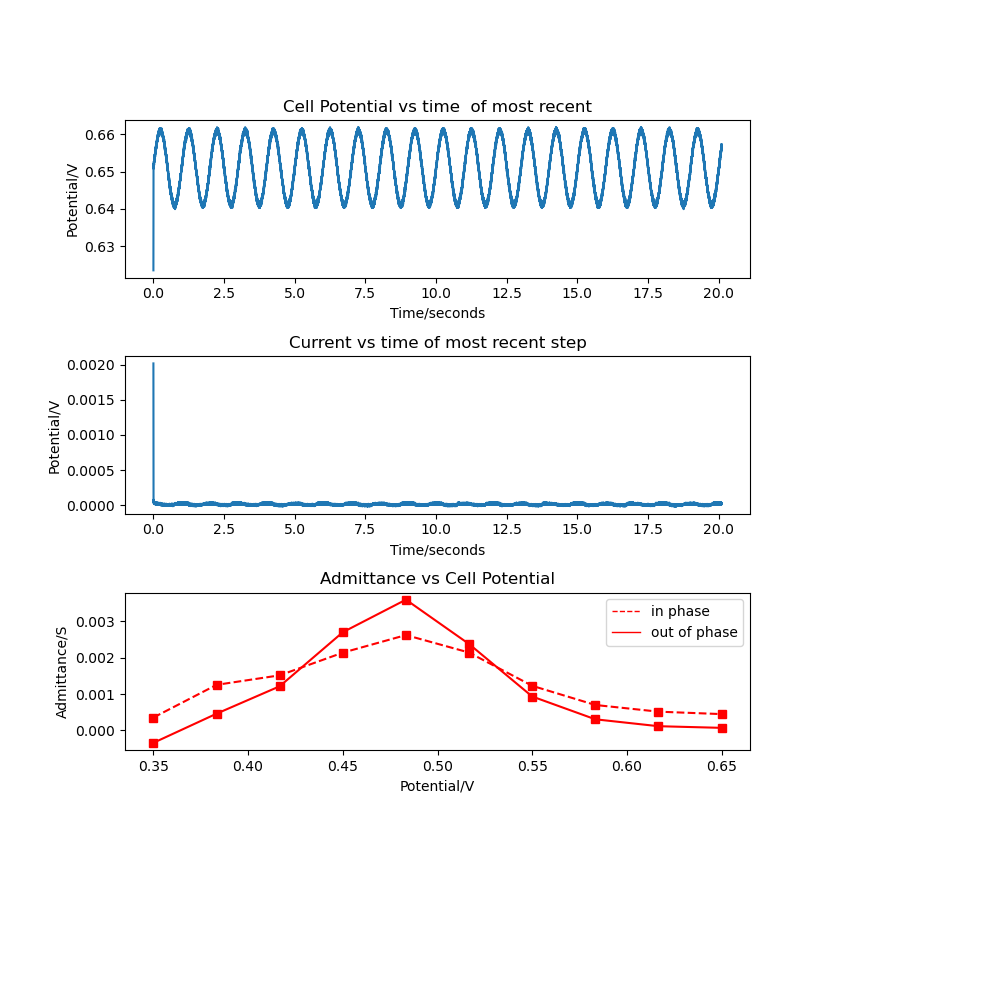

0.35
0.3833333333333333
0.41666666666666663
0.45
0.48333333333333334
0.5166666666666666
0.55
0.5833333333333334
0.6166666666666667
0.65


In [ ]:
import matplotlib
%matplotlib notebook
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 70em; width:120em}</style>"))

from cycler import cycler
cc1 = (cycler(color=list('rgbcmy')) *
    cycler(linestyle=['-', '--']))

'''basic acquisition params'''
# sampling rate (samples/s)  Use an integral multiple of 120/suse at least 3600 per volt
samp_rate = 3600   

# Rm resistance in Ohms
Rm = 1000

# hold time 
h_time = 0.1

# superimpose some AC signal on top 
AC_freq = 1#10**5/2**13 # frequency in Hz
E_AC = 0.01

# Dc potentials to scan 
start_pot = 0.35
end_pot = 0.65
num_DC = 10

# lists and arrays to to store data
DC_pot_tot = []
Y_in_total =[]
Y_out_total = []
cell_pot_in_total =[]
cell_pot_out_total = []
cell_pot_total = np.array([])
cell_current_total = np.array([])

# set up a 2 x 2 grid for the plot
grid = plt.GridSpec(3, 1, hspace=0.5)
fig = plt.figure(figsize = (10, 10))    

# set right edge of plot to be at 80% of fig width and bottom to be at 20% of fig height to fit everything.
plt.subplots_adjust(right=0.75)
plt.subplots_adjust(bottom=0.25)

#subplot updates
ax1 = fig.add_subplot(grid[0, 0])
ax2 = fig.add_subplot(grid[1, 0])
ax3 = fig.add_subplot(grid[2, 0])
#ax4 = fig.add_subplot(grid[3, 0])
plt.ion()
fig.show()
fig.canvas.draw()
# manually add legend
lines = Line2D([0], [0], color='red', label='in phase', linewidth=1, linestyle='--') 
lines2= Line2D([0], [0], color='red', label='out of phase', linewidth=1, linestyle='-') 


'''Loop for multiple potential steps'''
for DC_step in np.linspace(start_pot, end_pot, num_DC):
    print(DC_step)
    Y_in, Y_out, cell_pot_in, cell_pot_out, cell_pot, cell_current = acquire_data(E_AC, AC_freq, DC_step, samp_rate, h_time, Rm)
    #plt.plot(cell_pot)
    
    # append data
    Y_in_total.append(Y_in)
    Y_out_total.append(Y_out)
    cell_pot_in_total.append(cell_pot_out)
    cell_pot_out_total.append(cell_pot_out)
    cell_pot_total = np.concatenate((cell_pot_total, cell_pot))
    cell_current_total = np.concatenate((cell_current_total, cell_current))
    DC_pot_tot.append(DC_step)
    
    # recalcualte time after each step
    time = np.arange(0, len(cell_pot), 1)/samp_rate
    
    # plot updating
    ax1.clear()
    ax1.set_title(r'Cell Potential vs time  of most recent')
    ax1.set_xlabel('Time/seconds')
    ax1.set_ylabel('Potential/V')
    #ax1.plot(time, cell_pot_total)
    ax1.plot(time, cell_pot)
    
    ax2.clear()
    ax2.set_title(r'Current vs time of most recent step')
    ax2.set_xlabel('Time/seconds')
    ax2.set_ylabel('Potential/V')
    #ax1.plot(time, cell_pot_total)
    ax2.plot(time, cell_current)
    
    ax3.clear()
    ax3.set_prop_cycle(cc1)
    ax3.set_title(r'Admittance vs Cell Potential')
    ax3.set_ylabel('Admittance/S')
    ax3.set_xlabel('Potential/V')
    ax3.plot(DC_pot_tot, Y_in_total, marker='s')
    ax3.plot(DC_pot_tot, Y_out_total, marker='s')
    ax3.legend(handles = [lines, lines2])
    
    '''
    ax4.clear()
    ax4.set_title(r'Y_out vs Cell Potential')
    ax4.set_ylabel('Admittance/S')
    ax4.set_xlabel('Potential/V')
    ax4.scatter(DC_pot_tot, Y_out_total )
    '''
    # redrew plot with new data
    fig.canvas.draw()

    
'''SAVE DATA'''
# ask for the name of measurement this will be used for the filenames for the exported data and plots
filename = input('Name of measurement:')

#SAVE PLOT
plt.savefig(filename + '.png', dpi = 300, bbox_inches='tight')

#SAVE DATA
#plt.savefig(filename + '.png', dpi = 300, bbox_inches='tight')


'''export data'''
exported_data = pd.DataFrame({'Admittance in': Y_in_total , 'Admittance out': Y_out_total, 
                              'Cell Potential in':cell_pot_in_total, 
                              'Cell Potential out': cell_pot_out_total, 
                             'DC potential':DC_pot_tot})

exported_data.to_csv(filename + '.txt', index = False)


In [ ]:
'''Return potential to 0'''

# potential to do hold
E_hold = 0

# create potential profile for 10s hold
pot_profile = E_hold*np.ones(samp_rate)

a = pot_step_and_measure(pot_profile, samp_num = samp_rate)


In [ ]:
'''Import data'''

# filename
file = 'k.txt'

# import data
data = pd.read_csv(file)

In [ ]:
'''model parameters'''

E0 = 0 # standard potential of redox couple in V
n=1 # number of electrons per rxn
F=96485 # charge of electron in C/mol
R=8.31 # gas constant in J/mol/K
T=298 # temperature in K
A=1 # area in cm^2
D=1 # diffusion constant in cm^2/s
ctotal=1e-3 # total concentration of redox species in mol/cm^3
Rct0 = 0 # charge-transfer resistance at E0 in ohms
Cd = 10e-6 #  double layer capacitanc1e in F
Ru = 0 # uncompensated cell resistance in ohms

'''EIS Experimental Parameters'''
E_DC_EIS = 0 # DC potential of EIS in volts
Ru = 100 # uncompensated cell resistance in ohms

In [ ]:
'''Plot imported data with model'''

import matplotlib
%matplotlib notebook
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 70em; width:150em}</style>"))


# Frequency range array for EIS (default freq range goes from 0.1 Hz to 100 kHz )
powers = np.arange(-1, 5.1, 0.1)
freq_range = np.array([10**power for power in powers])

'''calcuate admittances and impedances of EIS by progressively adding components'''
# lists to store EIS sweep results
EIS_freq =[]
Yin_EIS_total=[]
Yout_EIS_total=[]
Zin_EIS_total=[]
Zout_EIS_total=[]

for E_DC in freq_range:
    
    # charge transfer resistance for redox assuming alpha = 0.5
    Rct_EIS = Rct0*(exp((E_DC_EIS-E0)/(2*R*T/n/F))+exp(-(E_DC_EIS-E0)/(2*R*T/n/F)))/2
    # equation 13 with E_cell replaced by E_DC
    Credox_EIS = (n**2*F**2/R/T)*A*(D/(2*pi*f_EIS))**0.5*ctotal*exp(-(E_DC_EIS-E0)/(R*T/n/F))*(1+exp(-(E_DC_EIS-E0)/(R*T/n/F)))**(-2)
    
    # in/out of-phase impedance of charge transfer
    Zin_EIS = Rct_EIS
    Zout_EIS = 0
    
    #in/out-of-phase impedance of redox branch of circuit
    Zin_EIS = Zin_EIS + 1./(2*pi*f_EIS*Credox_EIS)
    Zout_EIS = 1/(2*pi*f_EIS*Credox_EIS)
    
    #in/out-of-phase admittance of redox branch of circuit
    Yin_EIS = Zin_EIS/(Zin_EIS**2 + Zout_EIS**2)
    Yout_EIS = Zout_EIS/(Zin_EIS**2 + Zout_EIS**2)
    
    # in/out-of-phase admittance of redox and double-layer parallel branches of circuit
    Yin_EIS = Yin_EIS 
    Yout_EIS = Yout_EIS + 2*pi*f_EIS*Cd
    
    #in/out-of-phase impedance of redox and double-layer parallel branches of circuit
    Zin_EIS = Yin_EIS/(Yin_EIS**2 + Yout_EIS**2)
    Zout_EIS = Yout_EIS/(Yin_EIS**2 + Yout_EIS**2)
    
    #in/out of-phase impedance of entire circuit
    Zin_EIS = Zin_EIS + Ru
    Zout_EIS = Zout_EIS
    
    #in/out of-phase admittance of entire circuit
    Yin_EIS = Zin_EIS/(Zin_EIS**2 + Zout_EIS**2)
    Yout_EIS = Zout_EIS/(Zin_EIS**2 + Zout_EIS**2)
    
    # append data
    EIS_freq.append(f_EIS) 
    Yin_EIS_total.append(Yin_EIS)
    Yout_EIS_total.append(Yout_EIS)
    Zin_EIS_total.append(Zin_EIS)
    Zout_EIS_total.append(Zout_EIS)
    
# set up a 2 x 1 grid for the plot
grid = plt.GridSpec(2, 1, wspace=0, hspace=0.03)
fig5 = plt.figure("Figure 2", figsize = (9, 5))   
ax1 = fig5.add_subplot(grid[0, 0])
ax2 = fig5.add_subplot(grid[1, 0], sharex = ax1)

fig5.subplots_adjust(left=0.08, bottom=0.09, right=0.65, top=0.95, wspace=0, hspace=0.03)

from cycler import cycler
cc1 = (cycler(color=list('rgbcmy')) *
      cycler(linestyle=['-', '--']))
cc2 = (cycler(color=list('rgbcmy')))

# subplot 1
ax1.set_title('Electrochemical Impedance Spectra')
ax1.tick_params(axis='both',which='both',direction='in',right=True, top=True)
ax1.tick_params(labelbottom=False) 
ax1.set_prop_cycle(cc1)
ax1.plot(EIS_freq, Yin_EIS_total, label = '$R_{ct}$=' + str(Rct0) +'$\Omega; R_{u}$=' + str(Ru) +'$\Omega$ in-phase')
ax1.plot(EIS_freq, Yout_EIS_total, label = '$R_{ct}$=' + str(Rct0) +'$\Omega; R_{u}$=' + str(Ru) +'$\Omega$ out-of-phase')
data.plot(kind = 'scatter', x = 'Frequency/Hz', y = 'Y_in/S', label = 'data in phase', ax=ax1 ) # plot in phase admittance from imported data
data.plot(kind = 'scatter', x = 'Frequency/Hz', y = 'Y_out/S', label = 'data out of phase', ax=ax1 ) # plot out of phase admittance from imported data

ax1.set_ylabel('Admittance / S')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # move the legend



'''SAVE FIGURE'''
#plt.savefig(file + '.png', dpi = 300, bbox_inches='tight')